In [1]:
from Preprocess import *
from Model import *
from DataAnalysis import *

In [2]:
dic_csv = read_data()
df_var = make_dataframe(dic_csv)

In [3]:
concat_train_test(dic_csv, df_var)
loans = Merge(df_var, haveCategorical=True)

In [17]:
df_var['loan']

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1.0
1,5316,1801,930711,165960,36,4610,1.0
2,6863,9188,930728,127080,60,2118,1.0
3,5325,1843,930803,105804,36,2939,1.0
4,7240,11013,930906,274740,60,4579,1.0
...,...,...,...,...,...,...,...
349,4989,105,981205,352704,48,7348,NaN
350,5221,1284,981205,52512,12,4376,NaN
351,6402,6922,981206,139488,24,5812,NaN
352,5346,1928,981206,55632,24,2318,NaN


In [24]:
original_loan_per_year = loan_per_year(df_var['loan'], isMerged = False)




Loans of the year 1993


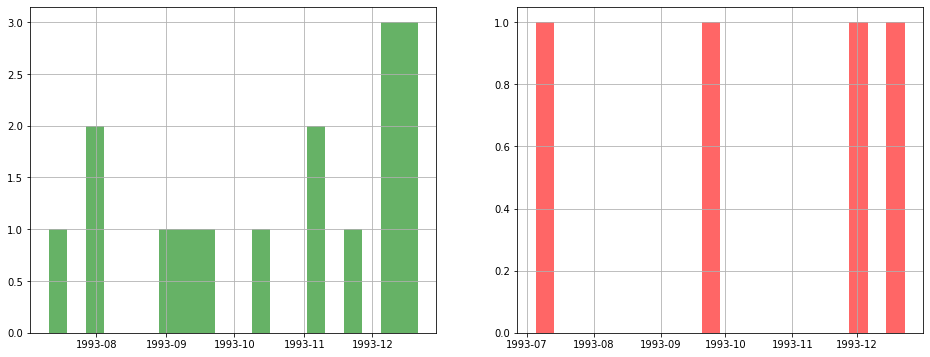

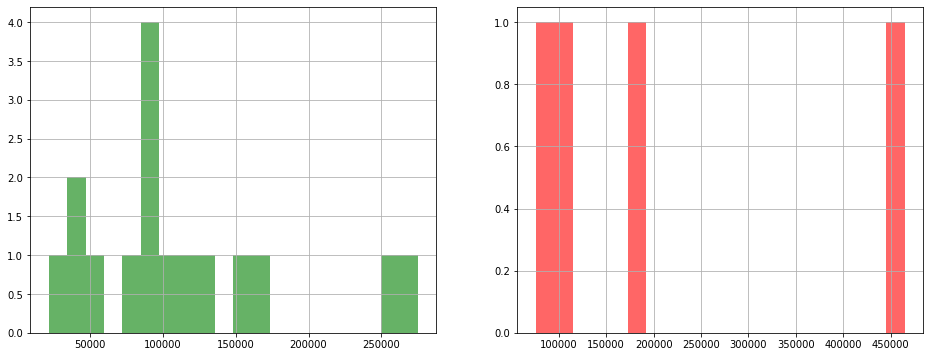

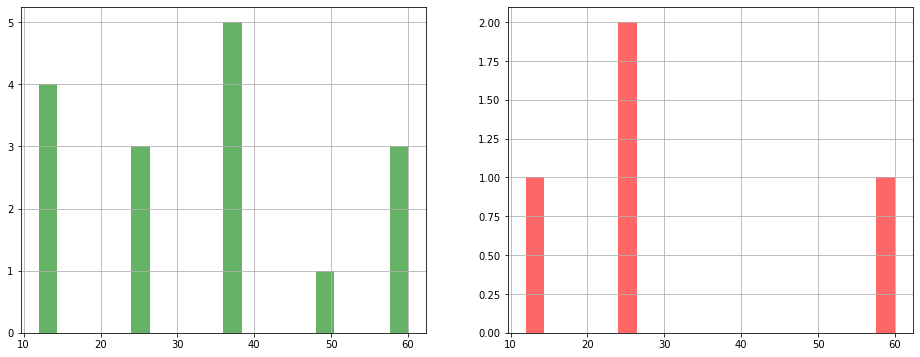

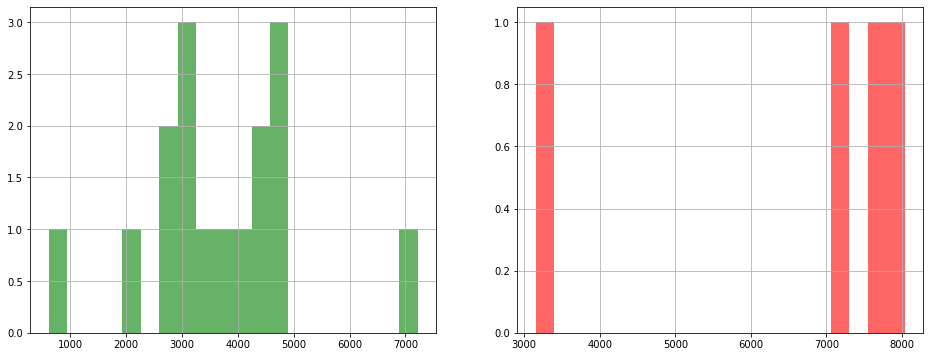



Loans of the year 1994


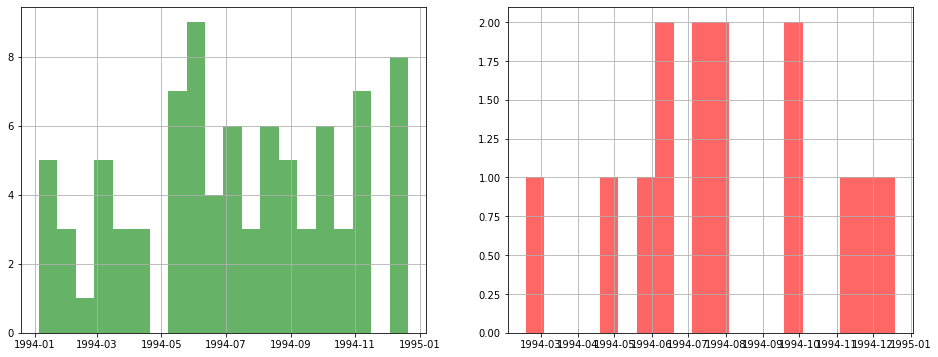

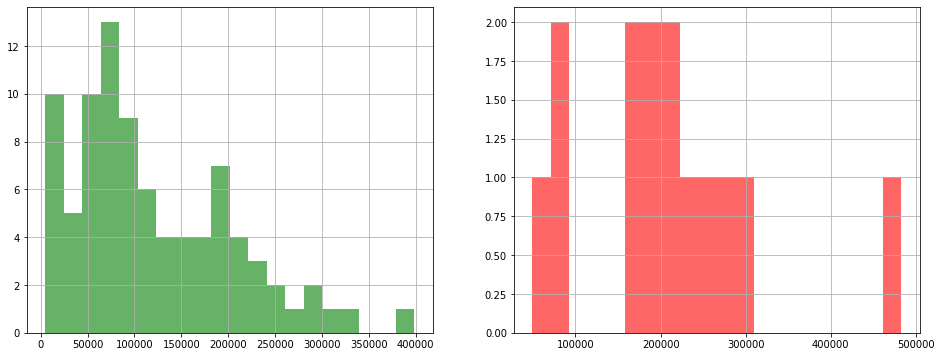

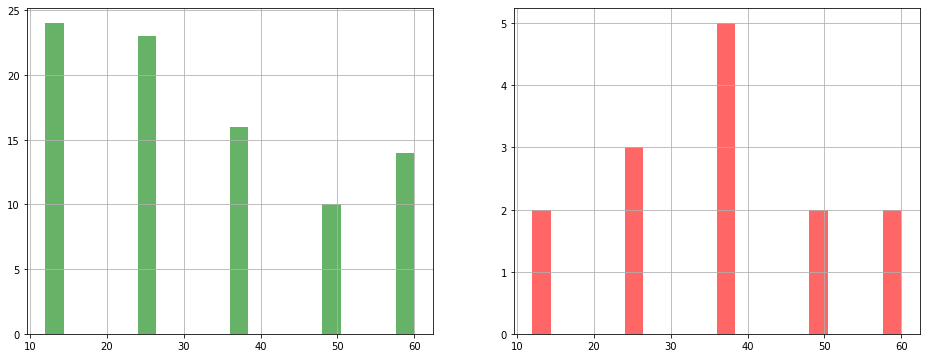

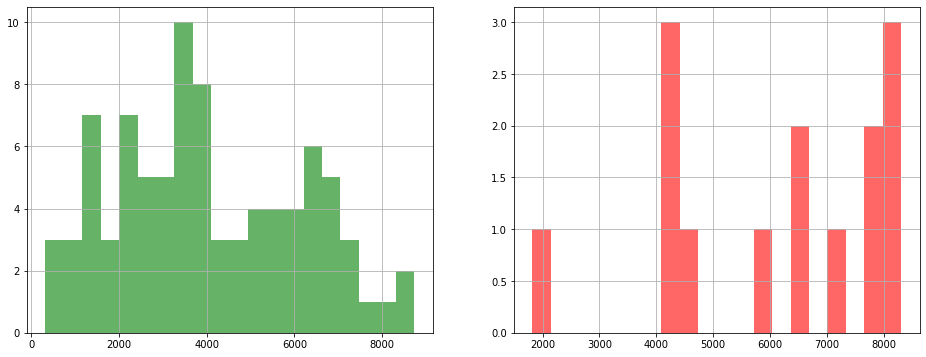



Loans of the year 1995


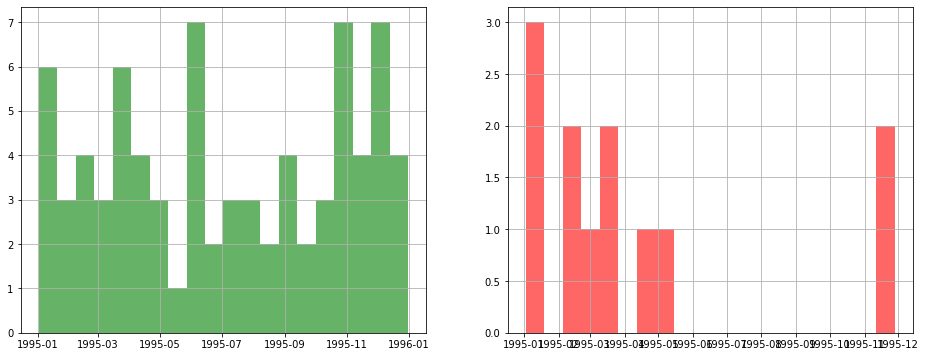

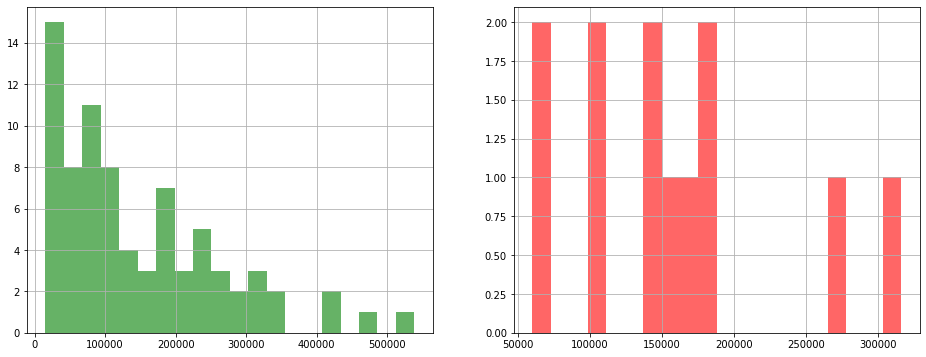

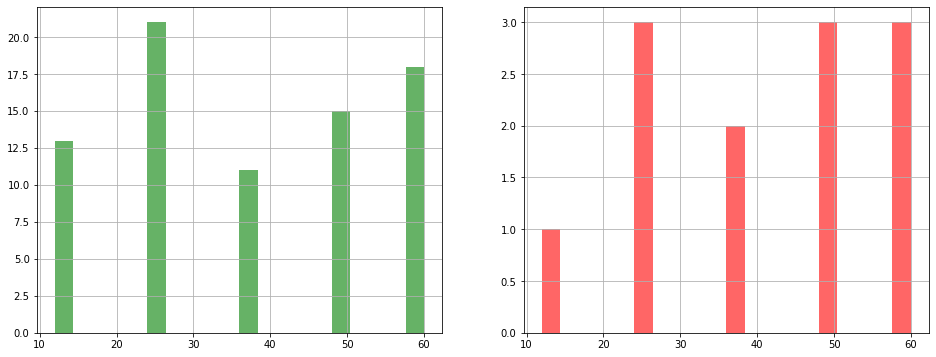

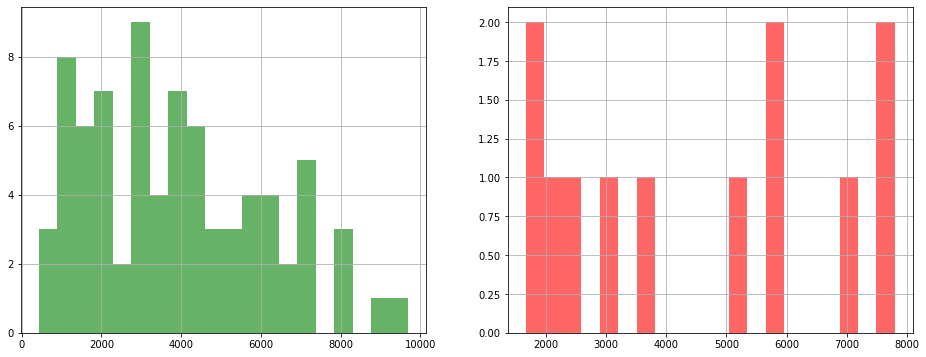



Loans of the year 1996


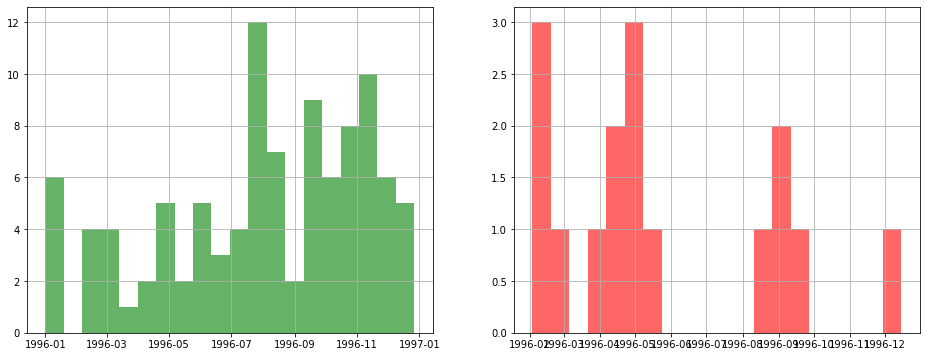

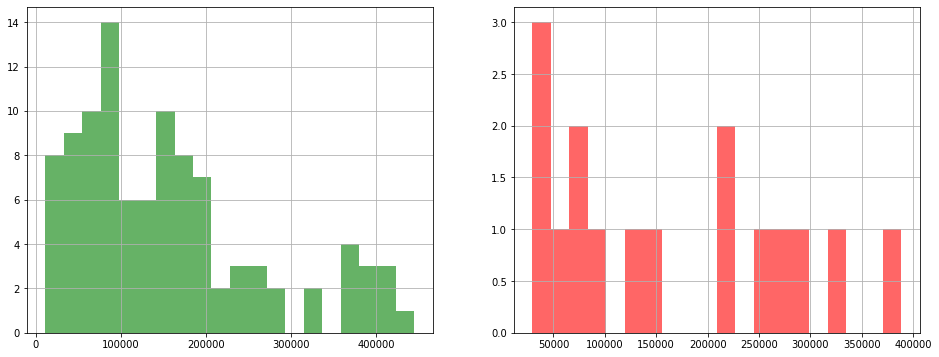

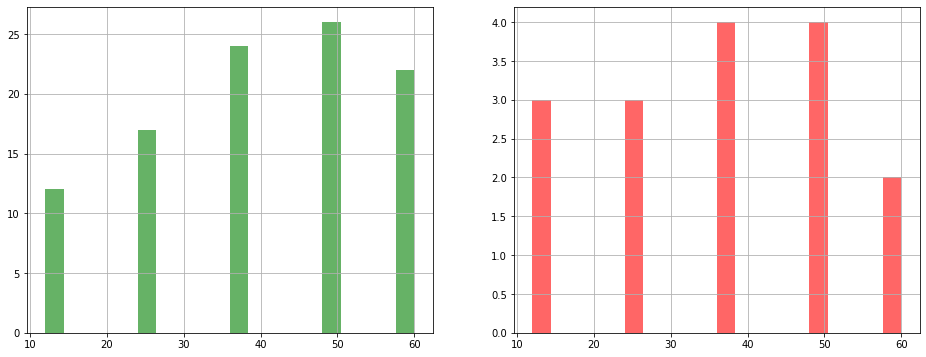

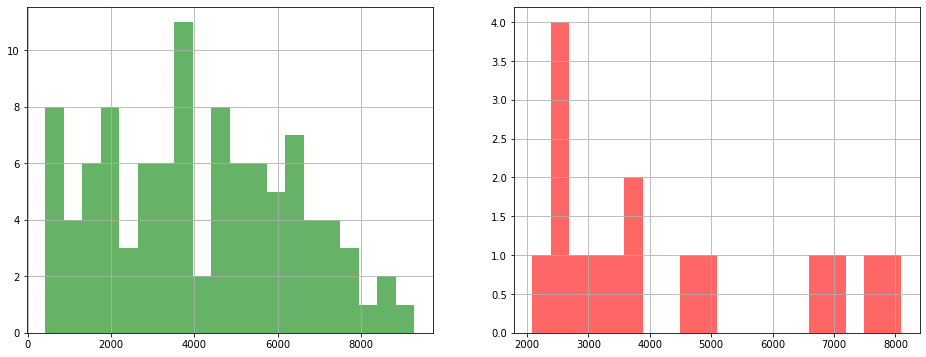



Loans of the year 1997


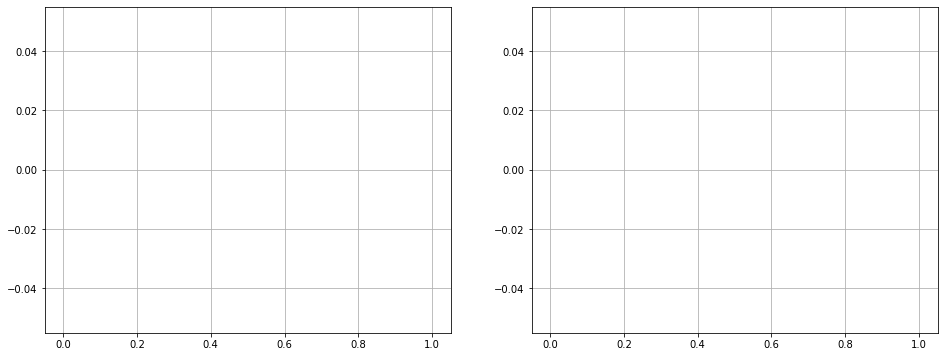

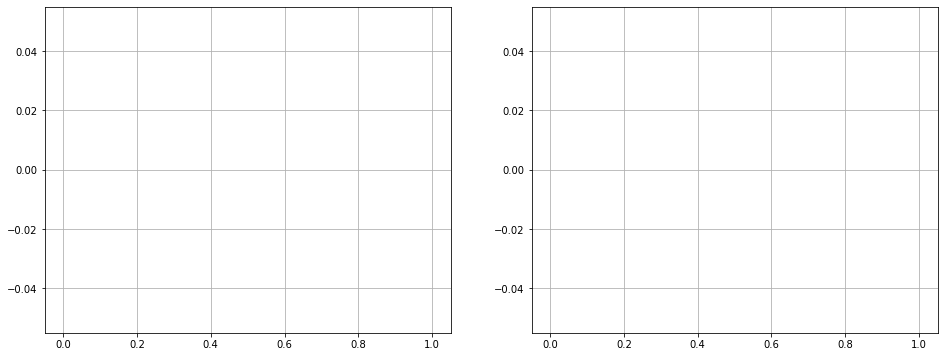

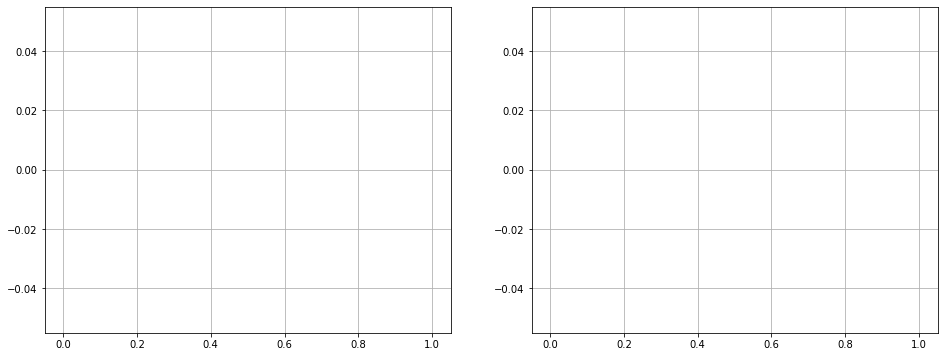

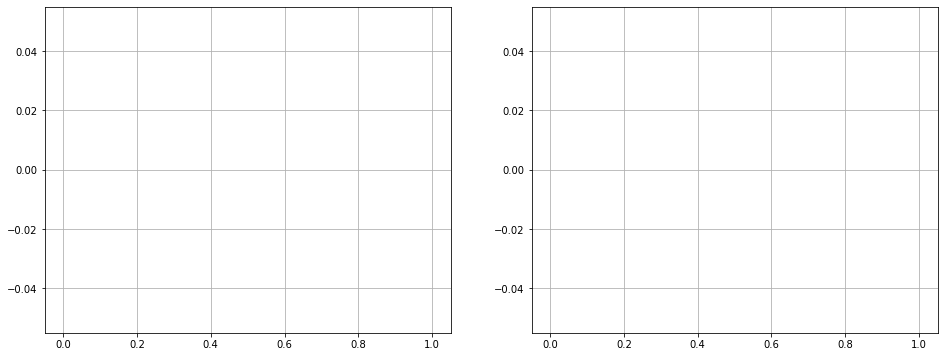



Loans of the year 1998


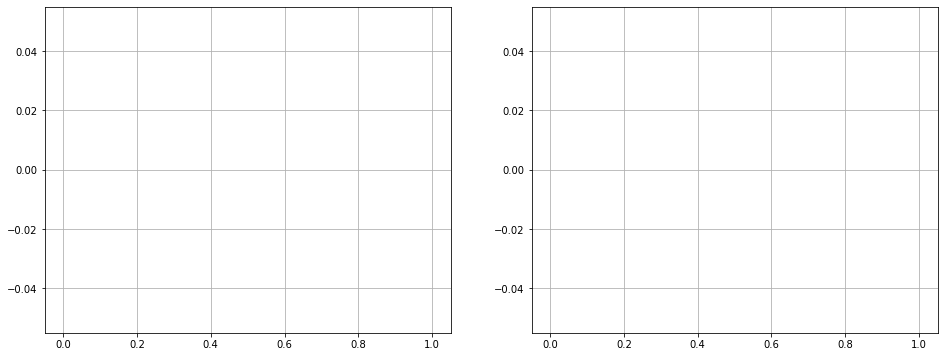

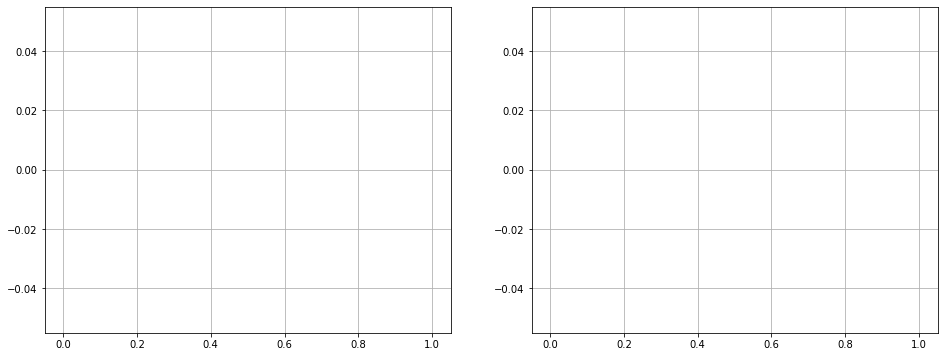

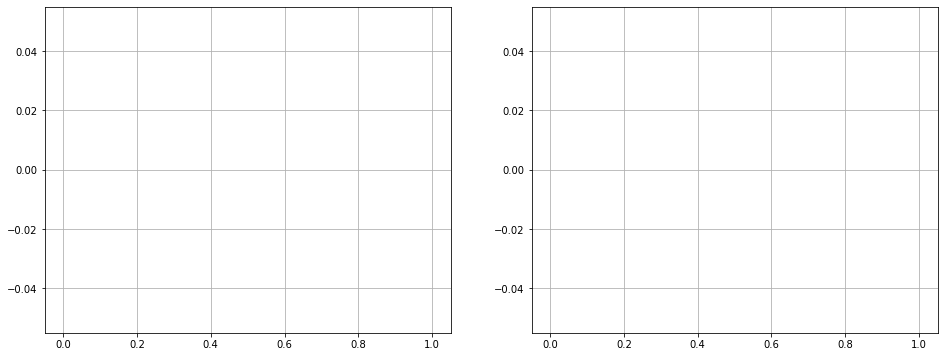

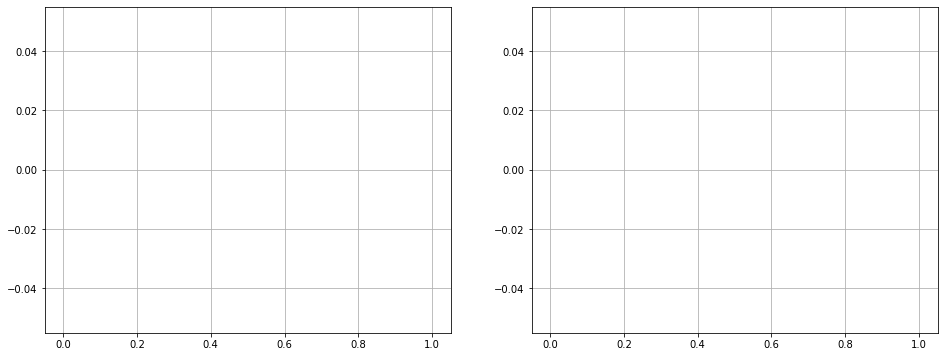

In [68]:
histDf(original_loan_per_year)